# **Group Project**

## **GRA 65602 - Strategic Asset Allocation**

This notebook contains the computations and models used to answer the questions

In [1]:
##
#  This cell cleans the environment
##
rm(list = ls())

In [2]:
##
#  This cell installs the packages for the libraries used
#  Uncomment if necessary
##
# install.packages(c("readxl", "ggplot2", "moments", "matlib", "zoo", "latex2exp"))

In [3]:
##
#  This cell loads the libraries and modules needed
#  @library readxl to read excel files
#  @library moments to compute statistics
#  @library zoo to compute correlations in rolling windows
#  @library latex2exp for formatting text in Latex
#  @library showtext to find fonts for plotting
#  @library systemfonts finds fonts for plotting
#  @module portConstruct with various portfolio construction methods
##
library(readxl)
library(moments)
library(zoo)
library(latex2exp)
library(showtext)
library(systemfonts)
source('portConstruct.R')

Warning message:
"package 'readxl' was built under R version 4.5.2"
Warning message:
"package 'moments' was built under R version 4.5.2"
Warning message:
"package 'zoo' was built under R version 4.5.2"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'latex2exp' was built under R version 4.5.2"
Warning message:
"package 'showtext' was built under R version 4.5.2"
Loading required package: sysfonts

Warning message:
"package 'sysfonts' was built under R version 4.5.2"
Loading required package: showtextdb

Warning message:
"package 'showtextdb' was built under R version 4.5.2"
Warning message:
"package 'systemfonts' was built under R version 4.5.2"
Warning message:
"package 'matlib' was built under R version 4.5.2"


In [4]:
##
#  This cell sets Times New Roman as font for the plots
##
tnr_path <- systemfonts::match_fonts("Times New Roman")$path
font_add("Times New Roman", regular = tnr_path)
showtext_auto()
par(family = "Times New Roman")

In [5]:
##
#  This cell loads and transforms the main data set
#  @dataset data.xlsx file containing the data
#  @return dataset expressed in decimals and formated date 
##
data                                      <- read_excel("data.xlsx", sheet = "csv")
data$Date                                 <- as.Date(data$Date, format = "%Y-%m-%d")
names(data)[names(data) == "Date"]        <- "date"
nonPercentage                             <- c("date", "P/D", "P/E")
data[, !(names(data) %in% nonPercentage)] <- data[, !(names(data) %in% nonPercentage)] / 100

In [6]:
##
#  2.1 This cell gets the data used 
##
selectColumns           <- c("date", "us_t1m", "us_infl", "wrld_eq", "wlrd_gbnd")
data7030                <- data[-1, selectColumns]
colnames(data7030)      <- c("date", "rf", "inflation", "equity", "bonds")
head(data7030)

date,rf,inflation,equity,bonds
<date>,<dbl>,<dbl>,<dbl>,<dbl>
1947-01-31,0.0002640758,0.006517691,0.0283385093,0.005332620
1947-02-28,0.0002852513,0.017576318,-0.0003775009,-0.003177945
1947-03-31,0.0002852513,0.000000000,0.0147280967,-0.002681048
1947-04-30,0.0002852187,-0.002272727,0.0078154075,0.002685794
1947-05-31,0.0002852662,0.005922551,-0.0121861152,0.002503421
1947-06-30,0.0002851915,0.006793478,0.0093457944,-0.004443557


[1] " Correlation between equities and bonds, cor(r_equity,r_bonds) = 0.3356"

[1] " Covariance between equities and bonds, cov(r_equity,r_bonds) = 0.00026"

[1] "First(mean) and second(variance) moments of the assets:"

asset,equity,bonds
mean,0.0057,0.0020
sigma,0.0391,0.0200
sigma2,0.0015,0.0004
sharpeRatio,0.1460,0.0977


[1] "-----------------------------------------------------------------------------------------------"

[1] "The infered relative risk aversion of the fund (gamma) is 2.3713"

[1] "-----------------------------------------------------------------------------------------------"

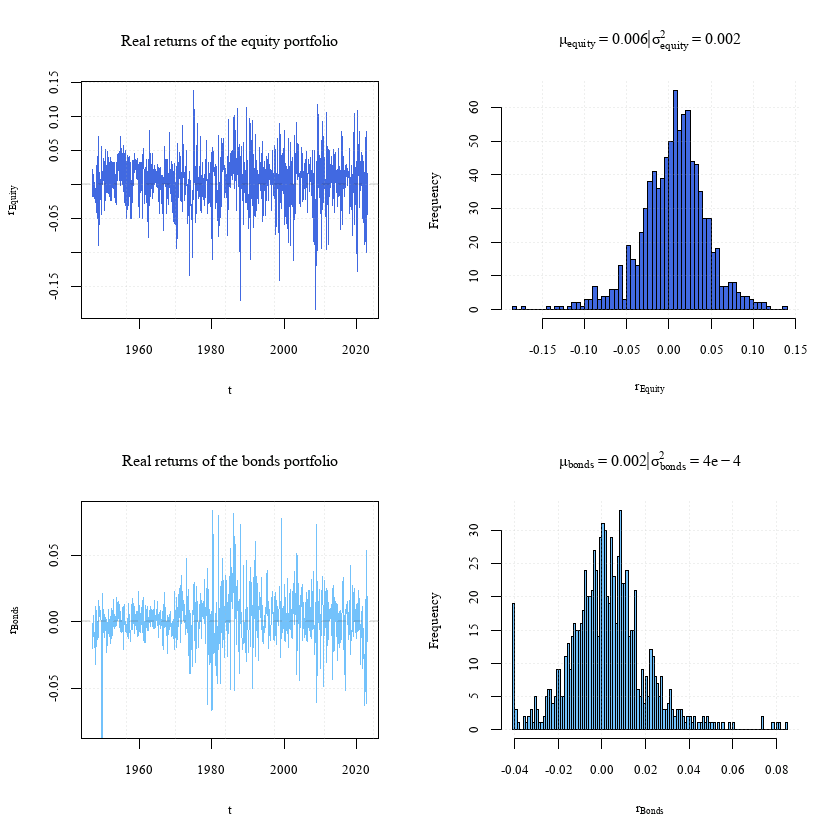

In [7]:
##
#  2.1 This cell infers the relative risk aversion of the fund (gamma)
#  based on the two moments of real returns from equities and bonds
##

# Gets the mean, variance and correlation of equities and bonds
# Uses real returns = (1 + nominal returns) / (1 +  inflation) - 1
rf             <- data7030$rf
rNominalEquity <- data7030$equity
rNominalBonds  <- data7030$bonds 
inflation      <- data7030$inflation
rRealRf        <- (1 + rf)             / (1 + inflation) - 1
rRealEquity    <- (1 + rNominalEquity) / (1 + inflation) - 1
rRealBonds     <- (1 + rNominalBonds)  / (1 + inflation) - 1

# Computes mean, variance, first and second moments of the 2 assets
muRealEquity      <- mean(rRealEquity)
muRealBonds       <- mean(rRealBonds)
varRealEquity     <- var(rRealEquity)
varRealBonds      <- var(rRealBonds)
sdRealEquity      <- sd(rRealEquity)
sdRealBonds       <- sd(rRealBonds)
corEquityBonds    <- cor(rRealEquity, rRealBonds)
covarEquityBonds  <- cov(rRealEquity, rRealBonds)
sharpeRatioEquity <- muRealEquity / sdRealEquity
sharpeRatioBonds  <- muRealBonds  / sdRealBonds

# Print data in a table
meanAssets      <- c(muRealEquity, muRealBonds)
varAssets       <- c(varRealEquity, varRealBonds)
sdAssets        <- c(sdRealEquity, sdRealBonds)
srAssets        <- c(sharpeRatioEquity, sharpeRatioBonds)
moments2Assets  <- data.frame(
                             asset       = c("equity", "bonds"),
                             mean        = round(meanAssets, 4),
                             sigma       = round(sdAssets, 4),
                             sigma2      = round(varAssets, 4),
                             sharpeRatio = round(srAssets, 4)   
                             )
paste(" Correlation between equities and bonds, cor(r_equity,r_bonds) =" ,round(corEquityBonds, 4))
paste(" Covariance between equities and bonds, cov(r_equity,r_bonds) =", round(covarEquityBonds, 5))
paste("First(mean) and second(variance) moments of the assets:")
t(moments2Assets)
paste("-----------------------------------------------------------------------------------------------")

# Compute the inferred risk aversion
# Two fund separation theorem
# gamma = (mu1 - m2) / (w1*(var1 + var2 + 2*cov(1,2)) - (var2 - cov(1,2)))
weightEquity <- 0.70
gamma        <- ((muRealEquity - muRealBonds) / 
                (weightEquity * (varRealEquity + varRealBonds + 2*covarEquityBonds) -
                (varRealBonds - covarEquityBonds))
                )
paste("The infered relative risk aversion of the fund (gamma) is", round(gamma, 4))
paste("-----------------------------------------------------------------------------------------------")

# Plot the moments of the and distributions of the 2 assets
# Plot the distributions of real returns for the assets
date <- data7030$date
par(mfrow = c(2,2), family = "Times New Roman")
colEquity <- "royalblue"
colBonds  <- "#73C2FB"

# Plots the real returns of equity
t1         <- "Real returns of the equity portfolio"
t2         <- TeX(paste("$\\mu_{equity} = ", round(muRealEquity, 3),
                "| \\sigma^2_{equity} = ", round(varRealEquity, 3),"$"
                  ))
x1         <- TeX("$t$")
y1         <- TeX("$r_{Equity}$")
x2         <- TeX("$r_{Equity}$")
colAbline  <- adjustcolor("black", alpha.f = 0.1)
plot(date, rRealEquity, type = "l", main = t1, xlab = x1, ylab = y1, lwd = 1, col = colEquity)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
hist(rRealEquity, breaks = 100, freq = T, main = t2, xlab = x2, col = colEquity)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# Plots the real returns of bonds
t1 <- "Real returns of the bonds portfolio"
t2 <- TeX(paste("$\\mu_{bonds} = ", round(muRealBonds, 3),
                "| \\sigma^2_{bonds} = ", round(varRealBonds, 4),"$"
         ))
x1 <- TeX("$t$")
y1 <- TeX("$r_{Bonds}$")
x2 <- TeX("$r_{Bonds}$")
# Truncates lowest 2% values to get a cleaner plot 
qL      <- quantile(rRealBonds, 0.02)
returns <- rRealBonds*(rRealBonds > qL) + qL*(rRealBonds <= qL)
plot(date, rRealBonds, type = "l", main = t1, xlab = x1, ylab = y1,
     ylim = c(quantile(rRealBonds, 0.001), max(rRealBonds)), lwd = 1, col = colBonds)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
hist(returns, breaks = 100, freq = T, main = t2, xlab = x2, col = colBonds)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

In [8]:
##
#  2.2 This Analyzes improvement in certainty equivalent if investing in rf
##

# Compute the unconstrained optimal portfolio
# Given a relative risk aversion and no risk free rate asset
assets             <- c("equity", "bonds") 
dataX              <- data7030[, assets]
mu                 <- colMeans(dataX)
sigma              <- cov(dataX)
gamma              <- gamma
wUncNoRf           <- uncMeanVar_ra(mu, sigma, gamma)
muUncNoRf          <- wUncNoRf %*% mu
sdUncNoRf          <- sqrt(wUncNoRf %*% sigma %*% wUncNoRf)
sharpeRatioUncNoRf <- (wUncNoRf %*% mu) / (sqrt(wUncNoRf %*% sigma %*% wUncNoRf))

# Print the portfolio metrics
paste("Unconstrained optimal portofolio, given a relative risk aversion (gamma) and no risk free asset")
paste("mu =", round(muUncNoRf, 4), "sd =", round(sdUncNoRf, 4), "SR=", round(sharpeRatioUncNoRf, 4))
data.frame(round(wUncNoRf, 4))
paste("-----------------------------------------------------------------------------------------------")

# Compute the tangency portfolio introducing risk free asset
rExcessEquity       <- rRealEquity - rRealRf
rExcessBonds        <- rRealBonds  - rRealRf
dataX               <- data.frame(rExcessEquity, rExcessBonds)
colnames(dataX)     <- c("equity", "bonds")
mu                  <- colMeans(dataX)
sigma               <- cov(dataX)
gamma               <- gamma
wTangency           <- uncTangent(mu, sigma)
muTangency          <- wTangency %*% mu
sdTangency          <- sqrt(wTangency %*% sigma %*% wTangency)
sharpeRatioTangency <- (wTangency %*% mu) / (sqrt(wTangency %*% sigma %*% wTangency))

# Print the portfolio metrics
paste("Tangency portolio, introducing risk free asset on excess retuns")
paste("mu =", round(muTangency, 4), "sd =", round(sdTangency, 4), "SR=", round(sharpeRatioTangency, 4))
data.frame(round(wTangency, 4))
paste("-----------------------------------------------------------------------------------------------")

#  Compute the unconstrained mean variance optimization given the risk aversion
#  and risk free asset
optLeverage          <- sharpeRatioTangency / (gamma*sdTangency)
optLeverage          <- as.numeric(optLeverage)
wUncWithRf           <- optLeverage*wTangency
wRf                  <- 1 - optLeverage
wUncWithRf           <- c(wUncWithRf, rf = wRf)
muUncWithRf          <- optLeverage * muTangency + mean(rRealRf)
sdUncWithRf          <- optLeverage * sdTangency 
sharpeRatioUncWithRf <- (muUncWithRf - mean(rRealRf)) / sdUncWithRf

# Print the portfolio metrics
paste("The optimal leverage SR_Tangency/(gamma*sd_Tangency) is", round(optLeverage, 4))
paste("Unconstrained optimal portfolio, introducing risk free asset and given risk aversion")
paste("mu =", round(muUncWithRf, 4), "sd =", round(sdUncWithRf, 4), "SR=", round(sharpeRatioUncWithRf, 4))
data.frame(round(wUncWithRf, 4))
paste("-----------------------------------------------------------------------------------------------")

# Compute the certainty equivalent for each of the portfolios built so far
ceNoRf     <- 1 + muUncNoRf   - 0.5*gamma*(sdUncNoRf)^2
ceTangency <- 1 + muTangency  - 0.5*gamma*(sdTangency)^2
ceWithRf   <- 1 + muUncWithRf - 0.5*gamma*(sdUncWithRf)^2

# Print the certainty euivalent for each of the portfolios
paste("The certainty equivalent (CE) for the unconstrained ptf with no rf asset is", round(ceNoRf, 4))
paste("The certainty equivalent (CE) for the tangency ptf is", round(ceTangency, 3))
paste("The certainty equivalent (CE) for the unconstrained ptf with rf asset is", round(ceWithRf, 4))

[1] "Unconstrained optimal portofolio, given a relative risk aversion (gamma) and no risk free asset"

[1] "mu = 0.0094 sd = 0.0466 SR= 0.2029"

,round.wUncNoRf..4.
,<dbl>
equity,1.2198
bonds,-0.2198


[1] "-----------------------------------------------------------------------------------------------"

[1] "Tangency portolio, introducing risk free asset on excess retuns"

[1] "mu = 0.0039 sd = 0.0264 SR= 0.1465"

,round.wTangency..4.
,<dbl>
equity,0.5672
bonds,0.4328


[1] "-----------------------------------------------------------------------------------------------"

[1] "The optimal leverage SR_Tangency/(gamma*sd_Tangency) is 2.3389"

[1] "Unconstrained optimal portfolio, introducing risk free asset and given risk aversion"

[1] "mu = 0.0093 sd = 0.0618 SR= 0.1465"

,round.wUncWithRf..4.
,<dbl>
equity,1.3267
bonds,1.0122
rf,-1.3389


[1] "-----------------------------------------------------------------------------------------------"

[1] "The certainty equivalent (CE) for the unconstrained ptf with no rf asset is 1.0069"

[1] "The certainty equivalent (CE) for the tangency ptf is 1.003"

[1] "The certainty equivalent (CE) for the unconstrained ptf with rf asset is 1.0047"

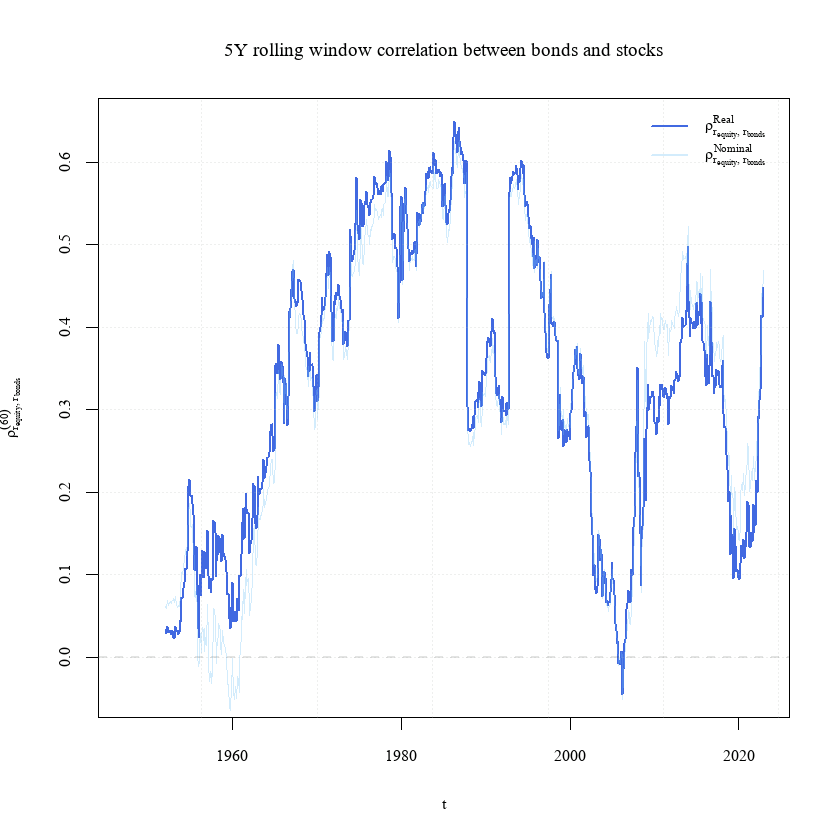

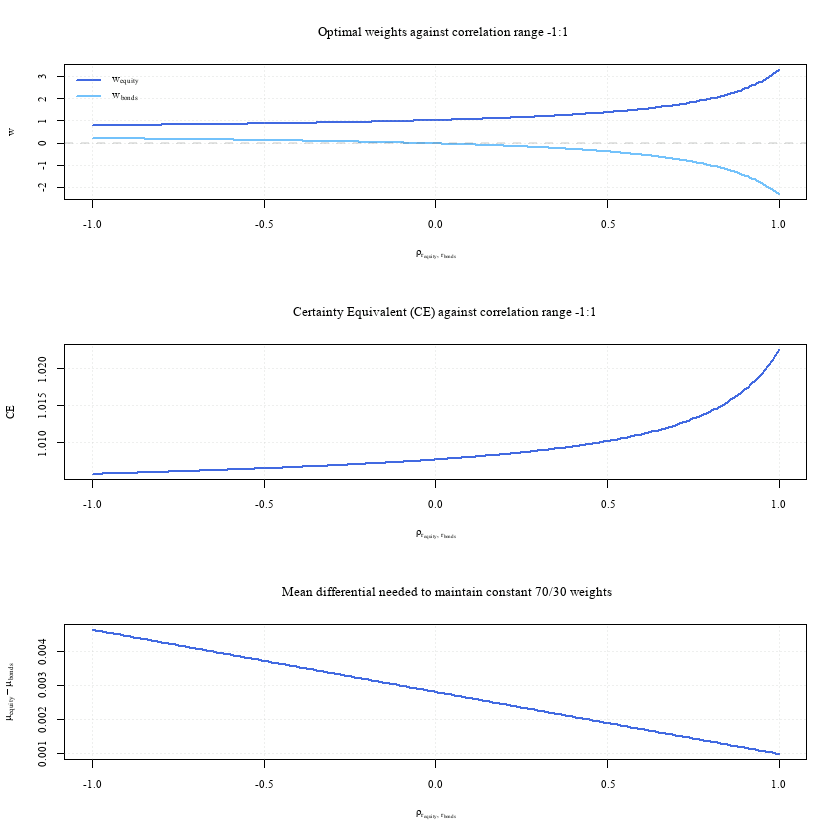

In [9]:
##
#  2.3 Plots 5Y rolling window correlation + finds optimal w and
#  ce over a relevant range of correlations +  meand differencial
#  to maintain constant portfolio weights
##

# Plot 5Y rolling window correlation between bonds and stocks
window                <- 60
xReal                 <- cbind(rRealEquity, rRealBonds)
rollWindowCorrReal    <- rollapply(
                                xReal,
                                width = window,
                                FUN = function(x) cor(x[,1], x[,2]),
                                by = 1,
                                align = "right",
                                fill = NA,
                                by.column = FALSE
                              )
xNominal              <- cbind(rNominalEquity, rNominalBonds)
rollWindowCorrNominal <- rollapply(
                                xNominal,
                                width = window,
                                FUN = function(x) cor(x[,1], x[,2]),
                                by = 1,
                                align = "right",
                                fill = NA,
                                by.column = FALSE
                              )
par(mfrow = c(1,1), family = "Times New Roman")
colReal    <- adjustcolor("royalblue", alpha.f = 1.0)
colNominal <- adjustcolor("#73C2FB", alpha.f = 0.3)
t          <- "5Y rolling window correlation between bonds and stocks"
plot(date, rollWindowCorrReal, type = "l", col = colReal , lwd = 2, main = t,
    xlab = TeX("$t$"), ylab = TeX("$\\rho^{(60)}_{r_{equity},r_{bonds}}$"))
lines(date,rollWindowCorrNominal, col = colNominal)
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)
legend("topright",
       legend = c(TeX("$\\rho^{Real}_{r_{equity},r_{bonds}}$"), 
       TeX("$\\rho^{Nominal}_{r_{equity},r_{bonds}}$")),
       col = c(colReal, colNominal),
       lwd = 2,
       bg = "white",
       bty = "n")

# Analyzes the optimal portfolio and CE for a relevant range of correlations
# Assume all moments remain constant, uses two fund separation theorem
gamma  <- gamma
mu1    <- muRealEquity
mu2    <- muRealBonds
var1   <- varRealEquity
var2   <- varRealBonds
sigma1 <- sdRealEquity
sigma2 <- sdRealBonds
cor    <- seq(-1.0, 1.0, length.out = 200)

# Solves for the weights and CE
# w1 = {1/gamma * (mu1-mu2) + (s2^2-cov(1,2))} / {s1^2 + s2^2 - 2*cov(1,2)}
# cov(1,2) = corr(1,2)*s1*s2
w1  <- rep(0, length(cor))
w2  <- rep(0, length(cor))
mu  <- rep(0, length(cor))
var <- rep(0, length(cor))
sd  <- rep(0, length(cor))
ce  <- rep(0, length(cor))

for (i in 1:length(cor)) {
  w1[i]  <- (((1/gamma)*(mu1-mu2) + var2 - cor[i]*sigma1*sigma2) /
             (var1 + var2 - 2*cor[i]*sigma1*sigma2)
            )
  w2[i]  <- 1 - w1[i]
  mu[i]  <- w1[i]*mu1 + w2[i]*mu2
  var[i] <- w1[i]^2*var1 + 2*w1[i]*w2[i]*cor[i]*sigma1*sigma2 + w2[i]^2*var2
  sd[i]  <- sqrt(var[i])
  ce[i]  <- 1+mu[i] + 0.5*gamma*sd[i]^2
}

# Plot weights against correlation
par(mfrow = c(3,1))
yMin <- min(w1, w2)
yMax <- max(w1,w2)
t    <- TeX("Optimal weights against correlation range -1:1")
plot(cor, w1, type = "l", col = "royalblue", ylim = c(yMin, yMax), lwd = 2,
     main = t, xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$w$"))
lines(cor, w2, col = "#73C2FB", lwd = 2)
legend("topleft",
       legend = c(TeX("$w_{equity}$"), 
       TeX("$w_{bonds}$")),
       col = c("royalblue", "#73C2FB"),
       lwd = 2,
       bg = "white",
       bty = "n")
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
abline(h = 0, col = colAbline, lwd = 2, lty = 2)

# Plot certainty equivalent against correlations
t <- TeX("Certainty Equivalent (CE) against correlation range -1:1")
plot(cor, ce, type = "l", col = "royalblue", lwd = 2, main = t,
     xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$CE$"))
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)

# How mean differential should change to maintain constant ptf weights
# w1 = 0.70
# mu1 - mu2 = gamma*w1*(s1^2+s2^2-2*cov(1,2) - s2^2 + cov(1,2)
w1          <- 0.70
gamma       <- gamma
mu1         <- mu1
mu2         <- mu2
var1        <- var1
var2        <- var2
sigma1      <- sigma1
sigma2      <- sigma2
cor         <- cor
mu1Minusmu2 <- rep(0, length(cor))
for (i in 1:length(cor)){
  mu1Minusmu2[i] <- (gamma*w1*(var1 + var2 - 2*cor[i]*sigma1*sigma2)
                     - var2 + cor[i]*sigma1*sigma2
                    )
}

# Plot expected return differential to maintain constant weights
t <- TeX("Mean differential needed to maintain constant 70/30 weights")
plot(cor, mu1Minusmu2, type = "l", lwd = 2, col = "royalblue", main = t,
     xlab = TeX("$\\rho_{r_{equity},r_{bonds}}$"), ylab = TeX("$\\mu_{equity}-\\mu_{bonds}$")
    )
grid(col = adjustcolor("gray70", alpha.f = 0.2), lwd = 1)
par(mfrow = c(1,1))